#### Instalar las librerias y setear el idioma, para poder descargar las imagenes que tienen los nombres en Ingles, seteaar tambien la zona horaria para la configuracion de las imagenes raster

In [2]:
## Intalar las librerias
defaultW <- getOption("warn")
options(warn = -1)
library(RNetCDF)
library(raster)
library(sp)
library(readxl)
library(rgeos)
library(lubridate)
Sys.setlocale("LC_TIME", "English") #setear en ingles el idioma
Sys.setenv(TZ = "EST") #swtear zona horaria

Loading required package: sp
code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpPolyPart" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpPolyPart" was not checked for suspicious field assignments (recommended package 'codetools' not available?)
code for methods in class "Rcpp_SpPolygons" was not checked for suspicious field assignments (recommended package 'codetools' not a

[1] "English_United States.1252"

In [3]:
#Abrir Datos actualizados - Julio 2021
BASE = read_excel("BASE.xlsx")
head(BASE)

FECHA,RR
1915-01-01,436.1
1915-02-01,425.4
1915-03-01,366.2
1915-04-01,108.5
1915-05-01,113.4
1915-06-01,37.6


In [4]:
mes = month(max(BASE$FECHA,na.rm = T),label = T,abbr = T)
anio = year(max(BASE$FECHA,na.rm = T))

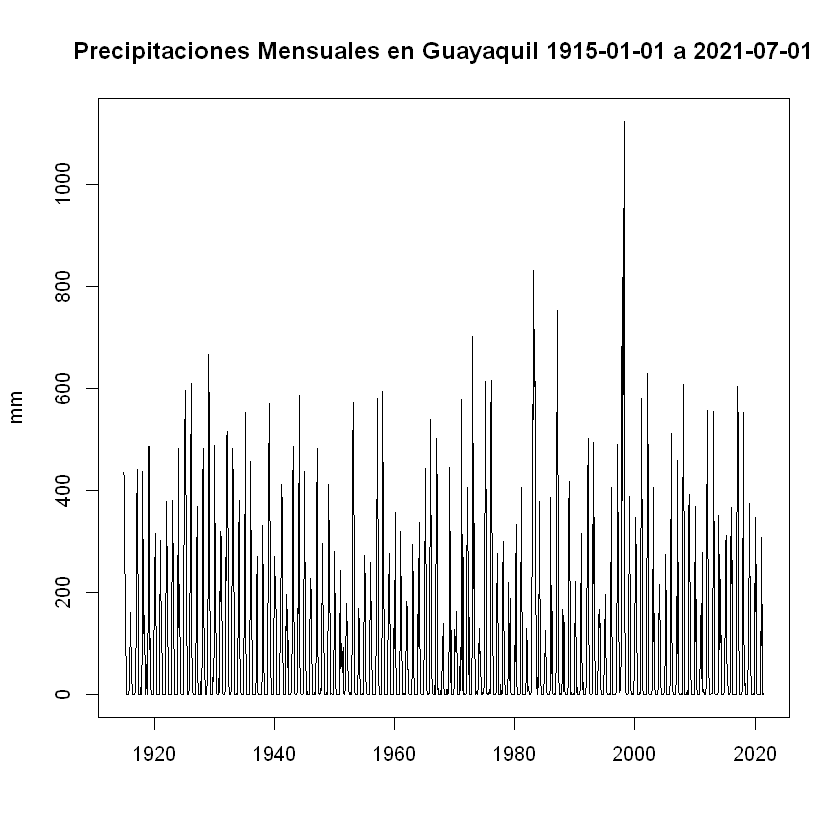

In [5]:
plot(BASE$FECHA,BASE$RR,type="l", main="Precipitaciones Mensuales en Guayaquil 1915-01-01 a 2021-07-01",xlab="",ylab="mm")

#### Ahora vamos a descargar la Data de Temperatura Superficial del Mar de la NOAA
#### Link = https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/%2830S%29%2830N%29RANGEEDGES/X/%28160W%29%2860W%29RANGEEDGES/T/%28Jan%201915%29%28Jul%202021%29RANGEEDGES/datafiles.html

In [6]:
#Descargar Archivo Netcdf
fname = paste0("https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/%2830S%29%2830N%29RANGEEDGES/X/%28160W%29%2860W%29RANGEEDGES/T/%28Jan%201915%29%28",mes,"%20",anio,"%29RANGEEDGES/data.nc")
download.file(fname,destfile = "data.nc", mode = 'wb')

#### Formatiamos las imagenes con sus limites utilizados en el corte, 160W a 60W en longitud, 30S a 30N en latitud

In [7]:
#ERSST version 5 (160W to 60W,30S to 30N), resolucion 1 Grado, 100 km
SST=RNetCDF::read.nc(RNetCDF::open.nc("data.nc"))
#Que empieza en -180
SST$X=SST$X-180
#funcion para rotar una matriz
rot=function(x) t(apply(x,2,rev))
SSTF=lapply(1:dim(SST$sst)[3],function(i)  raster(rot(rot(rot(SST$sst[,,i])))))

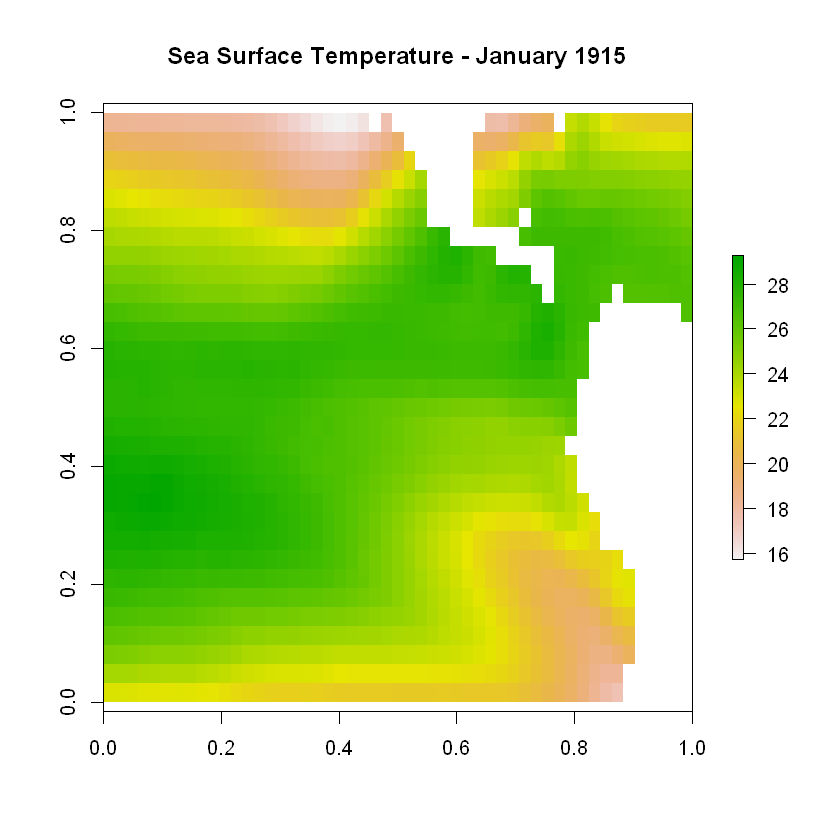

In [8]:
plot(SSTF[[1]], main = "Sea Surface Temperature - January 1915")

In [9]:
# Variable Tiempo para la serie de Tiempo
Tiempo=as.character(seq(as.Date("1915-01-01"),by = "month", len=nrow(BASE)))

In [10]:
head(Tiempo)

[1] "1915-01-01" "1915-02-01" "1915-03-01" "1915-04-01" "1915-05-01"
[6] "1915-06-01"

#### Le damos la respectiva proyección a cada imagen, y la extensión para ajustar a su resolución normal

In [11]:
n=dim(SST$sst)[3]
for(i in 1:n)
{
  extent(SSTF[[i]])=extent(min(SST$X),max(SST$X),min(SST$Y),max(SST$Y))
  proj4string(SSTF[[i]])=CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  names(SSTF[[i]])=paste0("SST",Tiempo[i],sep="_")
}

#### Vamos a crear imagenes con el valor de cada Precipitación, en una imagen de la misma resolucion de las Temperaturas Superfical del Mar, para sacar el mapa de correlación espacial, y conocer el poligono con la correlacion espacial mas significativas a las RR 

In [12]:
RR=BASE$RR
#Se reemplaza cada valor de la matriz por cada valor de precipitacion
MA=SSTF
for(i in 1:n) MA[[i]][!is.na(MA[[i]])]=RR[i]

#### Función que me permite sacar la correlacion espacial entre la Precipitacion y las Temperaturas Superficial del Mar

In [13]:
#Para conocer la correlacion espacial observada
ccf_raster=function(x,y)
{
  I=dim(x[[1]])[1]
  J=dim(x[[1]])[2]
  N=length(x)
  X=array(c(sapply(1:N, function(i) as.matrix(x[[i]]))), dim = c(I,J,N))
  Y=array(c(sapply(1:N, function(i) as.matrix(y[[i]]))), dim = c(I,J,N))
  COR=raster(t(sapply(1:I, function(i) sapply(1:J, function(j) cor(x=X[i,j,],y=Y[i,j,])))))
  extent(COR)=extent(x[[1]])
  proj4string(COR)=CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  return(COR)
}


#### A continuación dibujaremos una linea de contorno con la correlacion mayor a 0.7, ese sera el area que utilizaremos para cortar las imagenes

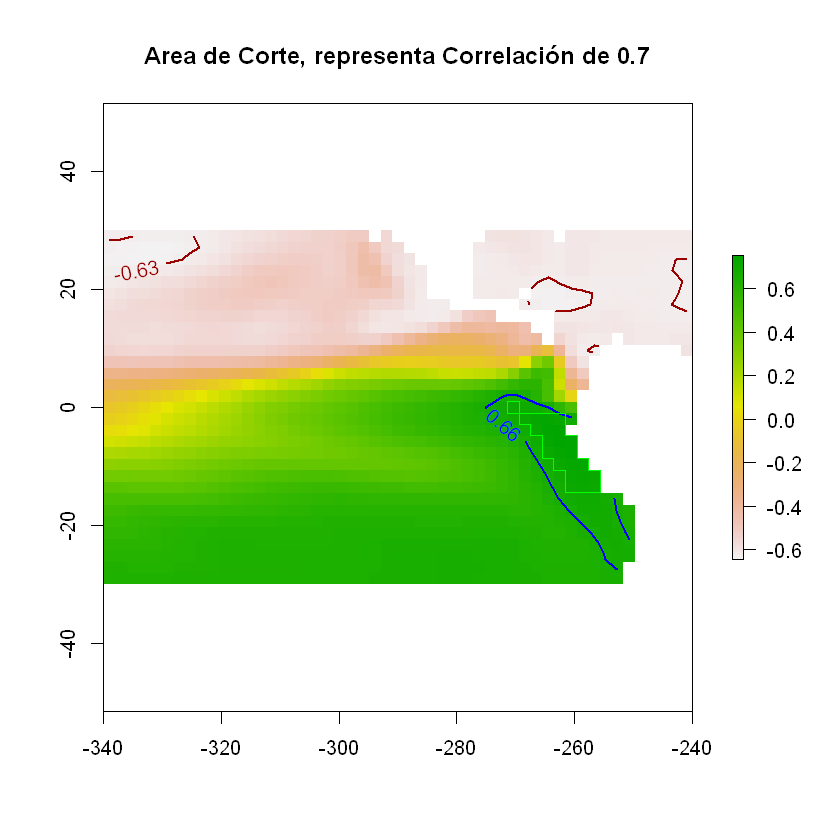

In [14]:
COR=ccf_raster(SSTF[(1:n)],MA[(1:n)])
#0.7 representa la correlacion en donde la isolinea es mayor, osea la mayor correlacion con el poligono
CORMAYOR=rasterToPolygons(COR,fun = function(x) x >= 0.7)
PCORMAYOR=gUnaryUnion(CORMAYOR)
#Ahora grafico la isolinea con correlacion 0.7
plot(COR, main = "Area de Corte, representa Correlación de 0.7")
contour(COR, levels=round(quantile(COR,c(0.05,0.95)),2),labcex = 1, col=c("#990000","blue"),add=TRUE,lwd=2)
lines(PCORMAYOR,col="green")

#### Ahora cortamos las imagenes con esa isolinea, y promediamos todos los pixeles dentro, tendremos 1 valor de Temperatura Superficial del Mar por mes desde 1915 hasta 2021

In [15]:
#Ahora cortamos esa zona con el poligono con mayor correlacion
SSTS = do.call(c,lapply(1:n, function(x) mean(as.matrix(mask(crop(SSTF[[x]],PCORMAYOR),PCORMAYOR)),na.rm=T)))
#Veamos la correlaacion entre la serie de Tiempo SST y RR
cor(RR,SSTS)

[1] 0.7458928

#### Por ultimo guardamos el archivo en un Libro de Excel que utilizaremos en Pyton

In [17]:
#Vamos a Guardar todo en un solo archivo
BASE=data.frame(Fecha=Tiempo,RR=RR,SST=SSTS)
writexl::write_xlsx(BASE,"DATA.xlsx",col_names = T)

In [18]:
head(BASE)

Fecha,RR,SST
1915-01-01,436.1,23.81849
1915-02-01,425.4,25.05968
1915-03-01,366.2,24.50934
1915-04-01,108.5,23.40319
1915-05-01,113.4,21.27035
1915-06-01,37.6,21.02337


#### Referencias

#### Huang, B., P. W. Thorne, V. F. Banzon, T. Boyer, G. Chepurin, J. H. Lawrimore, M. J. Menne, T. M. Smith, R. S. Vose, and H.-M. Zhang, 2017: Extended Reconstructed Sea Surface Temperature, version 5 (ERSSTv5): Upgrades, validations, and intercomparisons. J. Climate, 30, 8179-8205, doi:10.1175/JCLI-D-16-0836.1.

#### https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/